In [1]:
# 1. CARGA DE LIBRER√çAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "browser"
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.signal import periodogram
from sklearn.decomposition import PCA


In [2]:
# 2. CARGA DE DATOS
path_tsm = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos TSM consultoria estad√≠stica.xlsx'
path_chla = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos Chla consultoria estad√≠stica.xlsx'
path_coords = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Coordenadas zona costera occidental GC.csv'
path_oni = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\oni-Cold & Warm Episodes by Season.csv - Sheet1.csv'

tsm_df = pd.read_excel(path_tsm)
chla_df = pd.read_excel(path_chla)
coords_df = pd.read_csv(path_coords, header=None)
oni_df_raw  = pd.read_csv(path_oni)


In [3]:
tsm_df.columns = tsm_df.columns.str.strip()
chla_df.columns = chla_df.columns.str.strip()

# Derretir (melt) a formato largo
tsm_long = tsm_df.melt(
    id_vars=["FECHA", "A√ëO", "MES", "ESTACI√ìN DEL A√ëO", "EVENTO INTERANUAL"],
    value_vars=[col for col in tsm_df.columns if "Est" in col],
    var_name="estacion",
    value_name="TSM"
)

chla_long = chla_df.melt(
    id_vars=["FECHA", "A√ëO", "MES", "ESTACI√ìN DEL A√ëO", "EVENTO INTERANUAL"],
    value_vars=[col for col in chla_df.columns if "Est" in col],
    var_name="estacion",
    value_name="Chla"
)

# Unir datasets por columnas comunes
data_long = pd.merge(tsm_long, chla_long, on=["FECHA", "A√ëO", "MES", "ESTACI√ìN DEL A√ëO", "EVENTO INTERANUAL", "estacion"], how="outer")

# Convertir FECHA a datetime por si no est√°
data_long["FECHA"] = pd.to_datetime(data_long["FECHA"])

# Vista previa
data_long.sort_values("FECHA").head()

FECHA   A√ëO         MES ESTACI√ìN DEL A√ëO EVENTO INTERANUAL estacion  \
0  1981-09-01  1981  Septiembre            Oto√±o            Neutro  Est 10¬∞   
16 1981-09-01  1981  Septiembre            Oto√±o            Neutro   Est 9¬∞   
15 1981-09-01  1981  Septiembre            Oto√±o            Neutro   Est 8¬∞   
14 1981-09-01  1981  Septiembre            Oto√±o            Neutro   Est 7¬∞   
13 1981-09-01  1981  Septiembre            Oto√±o            Neutro   Est 6¬∞   

        TSM  Chla  
0   28.6250   NaN  
16  27.6583   NaN  
15  29.9750   NaN  
14  29.9917   NaN  
13  30.2750   NaN

In [4]:
# Asignar nombres de columnas correctos
coords_df.columns = ['lon', 'estacion_dummy', 'lat']

# Crear nombres de estaciones est√°ndar: Est 1¬∞, Est 2¬∞, ..., Est 17¬∞
coords_df['estacion'] = [f'Est {i}¬∞' for i in range(1, len(coords_df)+1)]

# Seleccionar columnas relevantes
coords_df = coords_df[['estacion', 'lon', 'lat']]

In [5]:
# Asegurarse de que los nombres de estaci√≥n coincidan exactamente
coords_df.columns = coords_df.columns.str.strip()
coords_df['estacion'] = coords_df['estacion'].str.strip()

# Hacer merge con el dataset largo
data_geo = pd.merge(data_long, coords_df, on="estacion", how="left")

# Revisar si alguna estaci√≥n no obtuvo coordenadas
missing_coords = data_geo[data_geo["lon"].isna()]["estacion"].unique()
if len(missing_coords) > 0:
    print("Estaciones sin coordenadas:", missing_coords)
else:
    print("Todas las estaciones tienen coordenadas.")

# Vista previa del DataFrame enriquecido
data_geo.tail()

Todas las estaciones tienen coordenadas.


FECHA   A√ëO      MES ESTACI√ìN DEL A√ëO EVENTO INTERANUAL estacion  \
7577 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 5¬∞   
7578 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 6¬∞   
7579 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 7¬∞   
7580 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 8¬∞   
7581 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 9¬∞   

          TSM    Chla    lon   lat  
7577  29.0756  0.2772 -110.8  25.3  
7578  28.6689  0.3656 -111.1  25.8  
7579  28.7222  0.5083 -111.2  26.3  
7580  28.4456  0.5119 -111.5  26.8  
7581  27.9233  0.9144 -111.9  27.2

In [6]:
# Eliminar filas que no tienen a√±os v√°lidos en la columna "Year"
oni_df_clean = oni_df_raw[oni_df_raw["Year"].str.isnumeric()].copy()

# Convertir a√±o y valores a tipos num√©ricos
oni_df_clean["Year"] = oni_df_clean["Year"].astype(int)
for col in oni_df_clean.columns[1:]:
    oni_df_clean[col] = pd.to_numeric(oni_df_clean[col], errors="coerce")

# Expansi√≥n a meses individuales
trimester_to_months = {
    "DJF": [(0, 12), (1, 1), (1, 2)],
    "JFM": [(1, 1), (1, 2), (1, 3)],
    "FMA": [(1, 2), (1, 3), (1, 4)],
    "MAM": [(1, 3), (1, 4), (1, 5)],
    "AMJ": [(1, 4), (1, 5), (1, 6)],
    "MJJ": [(1, 5), (1, 6), (1, 7)],
    "JJA": [(1, 6), (1, 7), (1, 8)],
    "JAS": [(1, 7), (1, 8), (1, 9)],
    "ASO": [(1, 8), (1, 9), (1, 10)],
    "SON": [(1, 9), (1, 10), (1, 11)],
    "OND": [(1, 10), (1, 11), (1, 12)],
    "NDJ": [(1, 11), (1, 12), (2, 1)],
}

oni_expanded = []

for _, row in oni_df_clean.iterrows():
    year = int(row["Year"])
    for trimester, months in trimester_to_months.items():
        oni_value = row[trimester]
        for offset, month in months:
            oni_year = year + (offset - 1)
            oni_expanded.append({"A√ëO": oni_year, "MES_NUM": month, "ONI": oni_value})

oni_monthly_df = pd.DataFrame(oni_expanded).drop_duplicates(subset=["A√ëO", "MES_NUM"])

# Clasificar ENSO
def clasificar_enso(val):
    if val >= 0.5:
        return "Ni√±o"
    elif val <= -0.5:
        return "Ni√±a"
    else:
        return "Neutro"

oni_monthly_df["ONI"] = pd.to_numeric(oni_monthly_df["ONI"], errors="coerce")
oni_monthly_df["ENSO_CLASE"] = oni_monthly_df["ONI"].apply(clasificar_enso)


# Mapeo manual de meses en espa√±ol a n√∫mero
meses_esp_map = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Aplicar el mapeo
data_geo["MES_NUM"] = data_geo["MES"].map(meses_esp_map)

# Verificar si hay valores nulos
print("Valores sin MES_NUM asignado:", data_geo["MES_NUM"].isna().sum())

# Volver a unir con oni_monthly_df
data_final = pd.merge(data_geo, oni_monthly_df, on=["A√ëO", "MES_NUM"], how="left")

# Vista para confirmar
data_final.tail(12)

Valores sin MES_NUM asignado: 0


FECHA   A√ëO      MES ESTACI√ìN DEL A√ëO EVENTO INTERANUAL estacion  \
7570 2018-10-01  2018  Octubre            Oto√±o              Ni√±o  Est 15¬∞   
7571 2018-10-01  2018  Octubre            Oto√±o              Ni√±o  Est 16¬∞   
7572 2018-10-01  2018  Octubre            Oto√±o              Ni√±o  Est 17¬∞   
7573 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 1¬∞   
7574 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 2¬∞   
7575 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 3¬∞   
7576 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 4¬∞   
7577 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 5¬∞   
7578 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 6¬∞   
7579 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 7¬∞   
7580 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 8¬∞   
7581 2018-10-01  2018  Octubre            Oto√±o              Ni√±o   Est 9¬∞   

          TSM    Chla    lon   lat  MES_NUM  ONI ENSO_CLASE  
7570  27.5944  1.2078 -114.0  29.7       10  0.5       Ni√±o  
7571  27.7656  1.5967 -114.5  30.2       10  0.5       Ni√±o  
7572  28.0322  1.7532 -114.5  30.7       10  0.5       Ni√±o  
7573  29.9133  0.1522 -109.3  23.8       10  0.5       Ni√±o  
7574  29.7672  0.1781 -109.7  24.2       10  0.5       Ni√±o  
7575  29.5744  0.2155 -110.1  24.6       10  0.5       Ni√±o  
7576  29.5261  0.2304 -110.5  24.8       10  0.5       Ni√±o  
7577  29.0756  0.2772 -110.8  25.3       10  0.5       Ni√±o  
7578  28.6689  0.3656 -111.1  25.8       10  0.5       Ni√±o  
7579  28.7222  0.5083 -111.2  26.3       10  0.5       Ni√±o  
7580  28.4456  0.5119 -111.5  26.8       10  0.5       Ni√±o  
7581  27.9233  0.9144 -111.9  27.2       10  0.5       Ni√±o

In [7]:
data_final.to_csv(r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\interim\AABR_Notebooks\data_final.csv', index=False)


Clustering

In [8]:
data_final_common = data_final[data_final["A√ëO"] >= 1998].copy()

In [9]:
data_mensual = data_final_common.copy()

In [10]:
# O bien: ver el contenido completo con NaNs
data_mensual[data_mensual[["TSM", "Chla", "ONI"]].isna().any(axis=1)]

Empty DataFrame
Columns: [FECHA, A√ëO, MES, ESTACI√ìN DEL A√ëO, EVENTO INTERANUAL, estacion, TSM, Chla, lon, lat, MES_NUM, ONI, ENSO_CLASE]
Index: []

In [11]:
# Agrupar por estaci√≥n y calcular estad√≠sticas
agg_df = data_final.groupby("estacion").agg({
    "TSM": ["mean", "std", "min", "max"],
    "Chla": ["mean", "std", "min", "max"],
    "ONI": "mean",  # opcional: sensibilidad promedio al ENSO
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas para facilitar
agg_df.columns = ["estacion", 
                  "TSM_mean", "TSM_std", "TSM_min", "TSM_max",
                  "Chla_mean", "Chla_std", "Chla_min", "Chla_max",
                  "ONI_mean", "lat", "lon"]

# Vista previa
agg_df.head()


estacion   TSM_mean   TSM_std  TSM_min  TSM_max  Chla_mean  Chla_std  \
0  Est 10¬∞  23.876132  4.954750  13.1833  31.8594   1.353704  0.779083   
1  Est 11¬∞  23.361319  5.050388  14.5000  31.4167   1.550120  0.830237   
2  Est 12¬∞  22.306692  5.041044  10.3688  31.9313   2.341487  1.555169   
3  Est 13¬∞  22.348910  4.954625  12.9083  30.6833   1.930828  1.146268   
4  Est 14¬∞  22.760935  5.715260  12.6167  39.3000   1.449363  0.837153   

   Chla_min  Chla_max  ONI_mean   lat    lon  
0    0.2677    5.8586  0.026009  27.6 -112.3  
1    0.2988    5.1281  0.026009  28.0 -112.6  
2    0.7282    9.0678  0.026009  28.5 -112.9  
3    0.6784    6.8713  0.026009  28.9 -113.2  
4    0.4391    6.9701  0.026009  29.4 -113.6

In [12]:
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas para clustering
features = ["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]
X = agg_df[features]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


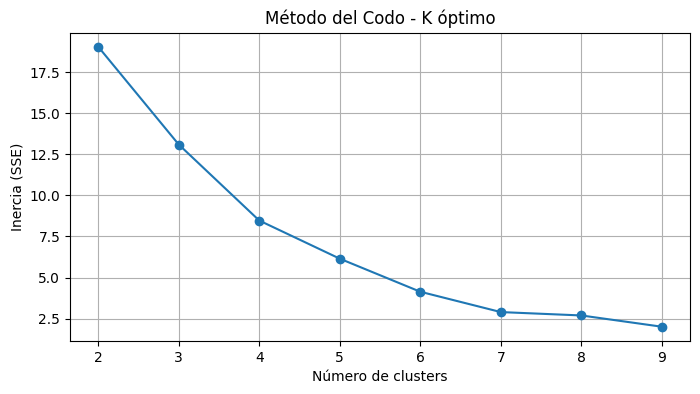

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Encontrar el n√∫mero √≥ptimo de clusters (m√©todo del codo)
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o')
plt.title("M√©todo del Codo - K √≥ptimo")
plt.xlabel("N√∫mero de clusters")
plt.ylabel("Inercia (SSE)")
plt.grid(True)
plt.show()


In [14]:
# k=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
agg_df["Cluster"] = kmeans_final.fit_predict(X_scaled)



---

### Regionalizaci√≥n espacio-temporal mediante clustering

Con el objetivo de identificar regiones oceanogr√°ficas homog√©neas dentro del noroeste del Golfo de California, se aplic√≥ un an√°lisis de **clustering no supervisado (KMeans)** sobre estad√≠sticas agregadas por estaci√≥n fija de monitoreo.

#### ¬øQu√© representa cada cluster?

Cada **cluster** define un grupo de estaciones con caracter√≠sticas ambientales similares, **resumidas estad√≠sticamente a lo largo del tiempo** (1997‚Äì2018 para Chl a, 1981‚Äì2018 para TSM). Es decir, **cada punto** representa el comportamiento medio y la variabilidad mensual de una estaci√≥n en el tiempo.

---

#### Variables consideradas para agrupar estaciones:

* **TSM\_mean**: Temperatura superficial del mar promedio
* **TSM\_std**: Variabilidad interanual de la TSM
* **Chla\_mean**: Concentraci√≥n promedio de clorofila a (indicador de productividad)
* **Chla\_std**: Variabilidad de la clorofila
* **ONI\_mean**: Influencia promedio del fen√≥meno ENSO (√≠ndice ONI)

Estas variables fueron **normalizadas** y se agruparon las estaciones mediante el algoritmo **KMeans**, seleccionando el n√∫mero √≥ptimo de clusters con el m√©todo del codo.

---

#### ¬øQu√© tipo de regionalizaci√≥n es?

Este an√°lisis produce una **regionalizaci√≥n espacio-temporal**, ya que:

* Se basa en la agregaci√≥n de datos temporales (mensuales durante varios a√±os) ‚Üí captura patrones persistentes en el tiempo.
* Se asocia a coordenadas fijas de estaciones ‚Üí tiene expresi√≥n espacial y se puede visualizar en mapas.

---

#### ¬øQu√© se interpreta de los clusters?

Los clusters permiten distinguir **zonas oceanogr√°ficas con comportamiento similar** en cuanto a temperatura y productividad:

* Zonas fr√≠as y altamente productivas (norte).
* Zonas c√°lidas y oligotr√≥ficas (sur).
* Zonas de transici√≥n con variabilidad mixta (centro).

Estos patrones ayudan a entender la **din√°mica estructural** del Golfo de California y pueden ser √∫tiles para:

* An√°lisis ecol√≥gicos (e.g., distribuci√≥n de especies).
* Evaluaci√≥n de impacto clim√°tico (ENSO).
* Planificaci√≥n de monitoreo o conservaci√≥n marina.

---


In [15]:
import folium

# Crear mapa base centrado en el Golfo de California
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# Paleta simple para clusters (puedes personalizar)
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']

# A√±adir cada estaci√≥n como punto
for _, row in agg_df.iterrows():
    cluster_id = int(row["Cluster"])
    color = colores[cluster_id % len(colores)]

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        popup=(f'Estaci√≥n: {row["estacion"]}<br>'
               f'Cluster: {cluster_id}<br>'
               f'TSM_mean: {row["TSM_mean"]:.2f} ¬∞C<br>'
               f'Chla_mean: {row["Chla_mean"]:.2f} mg/m¬≥')
    ).add_to(m)

m


In [16]:
# Agrupar por Cluster y calcular estad√≠sticas descriptivas
cluster_summary = agg_df.groupby("Cluster").agg({
    "TSM_mean": ["mean", "std"],
    "TSM_std": "mean",
    "Chla_mean": ["mean", "std"],
    "Chla_std": "mean",
    "ONI_mean": "mean",
    "lat": "mean",
    "lon": "mean",
    "estacion": "count"
}).rename(columns={"estacion": "n_estaciones"})

# Renombrar columnas para mayor claridad
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)
cluster_summary

Cluster  TSM_mean_mean  TSM_mean_std  TSM_std_mean  Chla_mean_mean  \
0        0      22.993072      0.779115      5.085643        2.015258   
1        1      25.021472      0.348854      4.197048        0.838282   
2        2      23.552444      0.589417      5.092072        1.381550   
3        3      25.978797      0.259994      3.640214        0.488509   

   Chla_mean_std  Chla_std_mean  ONI_mean_mean  lat_mean  lon_mean  \
0       0.223643       1.254085       0.026009    29.575  -113.775   
1       0.054534       0.599949       0.026009    25.800  -111.020   
2       0.147524       0.838903       0.026009    28.380  -112.880   
3       0.080428       0.353612       0.026009    24.200  -109.700   

   n_estaciones_count  
0                   4  
1                   5  
2                   5  
3                   3


---

### **Interpretaci√≥n de Clusters**

#### **Cluster 0 ‚Äî Zona Norte / Productiva y fr√≠a**

* **TSM media**: 22.99‚ÄØ¬∞C (m√°s baja de todos)
* **Chl a media**: 2.02‚ÄØmg/m¬≥ (m√°s alta de todos)
* **Variabilidad alta en TSM (std ‚âà 5.1)** y **Chla (std ‚âà 1.25)**
* **Ubicaci√≥n promedio**: lat 29.57, lon -113.77 (zona norte-occidental)
* **Interpreta como**: Aguas fr√≠as y muy productivas ‚Üí posiblemente influenciadas por afloramientos o din√°mica costera del norte del Golfo de California.

---

#### **Cluster 1 ‚Äî Zona Central con condiciones c√°lidas-mesotr√≥ficas**

* **TSM media**: 25.02‚ÄØ¬∞C
* **Chl a media**: 0.84‚ÄØmg/m¬≥
* **Moderada variabilidad en TSM y Chla**
* **Ubicaci√≥n promedio**: lat 25.8, lon -111.0 (centro del Golfo)
* **Interpreta como**: Aguas c√°lidas, productividad media ‚Üí transici√≥n entre el norte productivo y el sur oligotr√≥fico.

---

#### **Cluster 2 ‚Äî Subtropical templado y moderadamente productivo**

* **TSM media**: 23.55‚ÄØ¬∞C
* **Chl a media**: 1.38‚ÄØmg/m¬≥
* **Alta variabilidad de TSM (std ‚âà 5.1) y Chl a (std ‚âà 0.83)**
* **Ubicaci√≥n promedio**: lat 28.38, lon -112.88 (noroeste-central)
* **Interpreta como**: Zona de transici√≥n norte-centro, con variabilidad estacional marcada y productividad intermedia.

---

#### **Cluster 3 ‚Äî Zona Sur / Oligotr√≥fica y c√°lida**

* **TSM media**: 25.98‚ÄØ¬∞C (m√°s alta de todos)
* **Chl a media**: 0.49‚ÄØmg/m¬≥ (m√°s baja)
* **Baja variabilidad TSM (std ‚âà 3.64), Chl a (std ‚âà 0.35)**
* **Ubicaci√≥n promedio**: lat 24.2, lon -109.7 (extremo sur)
* **Interpreta como**: Aguas c√°lidas y pobres en nutrientes ‚Üí t√≠pico de zonas oligotr√≥ficas tropicales o subtropicales.

---

### üß≠ **Resumen regional**

| Cluster | Zona geogr√°fica | Temperatura | Clorofila | Productividad | Comentario                |
| ------- | --------------- | ----------- | --------- | ------------- | ------------------------- |
| 0       | Norte           | Fr√≠a        | Alta      | Muy alta      | Aguas ricas en nutrientes |
| 1       | Centro          | C√°lida      | Moderada  | Media         | Transici√≥n mesotr√≥fica    |
| 2       | Centro-Norte    | Templada    | Moderada  | Intermedia    | Alta variabilidad         |
| 3       | Sur             | Muy c√°lida  | Baja      | Baja          | Zona oligotr√≥fica         |

---

In [17]:
# Unir etiquetas de cluster al dataset mensual
data_final_clustered = pd.merge(data_final, agg_df[["estacion", "Cluster"]], on="estacion", how="left")


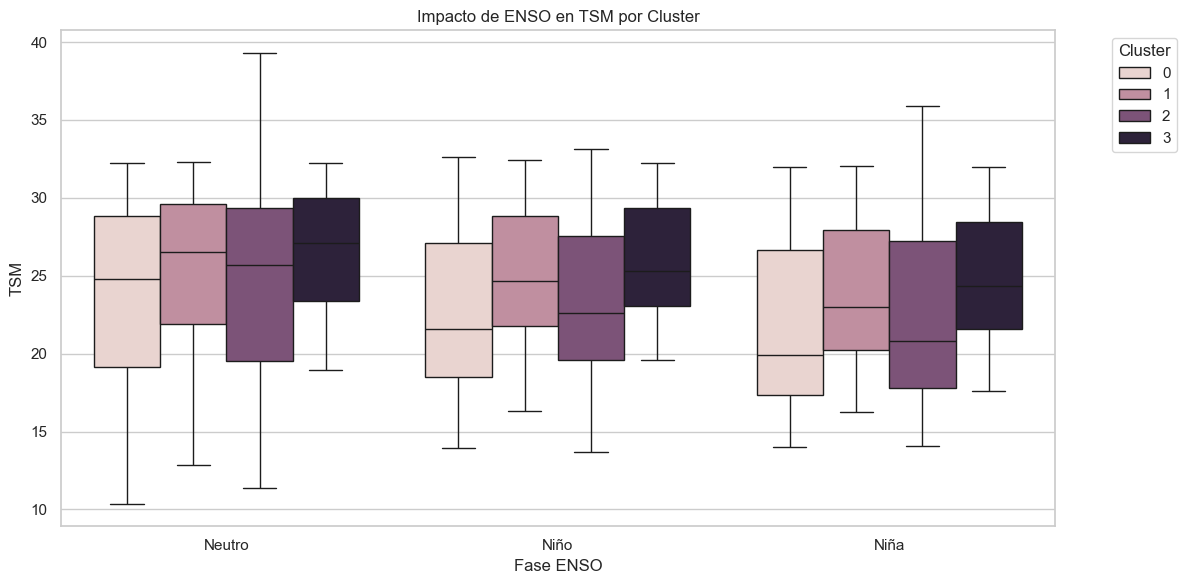

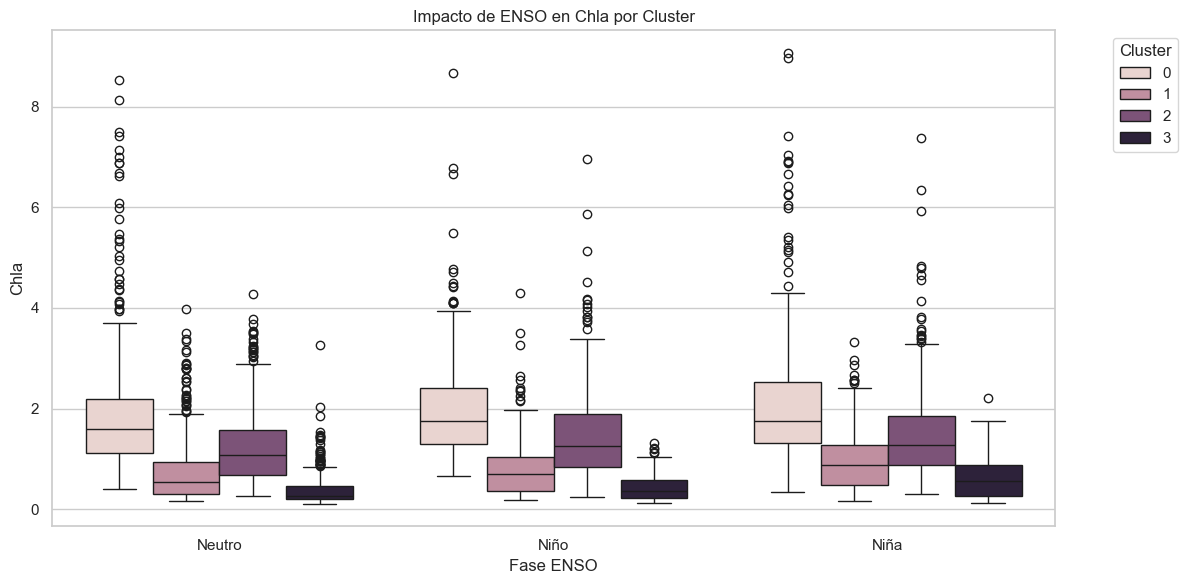

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Variables a graficar
for var in ['TSM', 'Chla']:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data_final_clustered, x='ENSO_CLASE', y=var, hue='Cluster')
    plt.title(f'Impacto de ENSO en {var} por Cluster')
    plt.xlabel('Fase ENSO')
    plt.ylabel(var)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



---

### An√°lisis de respuesta al ENSO por regi√≥n (cluster)

Se utilizaron boxplots para visualizar c√≥mo var√≠an las condiciones **ambientales promedio mensuales** de cada regi√≥n (cluster) en funci√≥n de las fases del **fen√≥meno ENSO**:

* **Ni√±o** (ONI ‚â• 0.5)
* **Ni√±a** (ONI ‚â§ -0.5)
* **Neutro** (ONI entre -0.5 y 0.5)

Las variables evaluadas fueron:

* **Temperatura superficial del mar (TSM)**
* **Concentraci√≥n de clorofila a (Chl a)**

---

### Observaciones clave

#### 1. **Temperatura superficial (TSM)**

* Todos los clusters muestran un patr√≥n **coherente de aumento en eventos Ni√±o**, y reducci√≥n ligera en eventos Ni√±a.
* El **Cluster 3 (zona sur)** presenta las TSM m√°s altas en todas las fases, y es menos afectado por ENSO.
* **Clusters 0 y 2 (zonas norte y centro-norte)** presentan mayor variabilidad en TSM, especialmente bajo condiciones Neutras y Ni√±o.

#### 2. **Clorofila a (Chl a)**

* La **productividad (Chl a)** es claramente m√°s alta en **Cluster 0**, consistente con aguas fr√≠as del norte.
* En eventos **Ni√±o**, se observa una ligera **reducci√≥n de Chl a en la mayor√≠a de los clusters**, indicando que este fen√≥meno puede afectar la productividad.
* En eventos **Ni√±a**, la Chl a tiende a aumentar ligeramente en todos los clusters, especialmente en el norte (Cluster 0), lo que sugiere condiciones m√°s favorables para afloramientos o mezcla vertical.

---

### Conclusi√≥n

Estos resultados sugieren que:

* **ENSO tiene un efecto t√©rmico claro** (m√°s caliente en Ni√±o, m√°s fr√≠o en Ni√±a).
* La **productividad biol√≥gica responde de manera regionalizada**, siendo m√°s sensible en las zonas norte y centro.
* La **zona sur (Cluster 3)** es m√°s estable t√©rmica y biol√≥gicamente, reflejando caracter√≠sticas de aguas subtropicales u oligotr√≥ficas.

Este tipo de an√°lisis permite evaluar la **sensibilidad clim√°tica regional** en el Golfo de California y puede ser √∫til para modelos ecol√≥gicos, pesqueros o de conservaci√≥n.

---

# Estacionalidad mensual por cluster

Para analizar la **estacionalidad** por regi√≥n (cluster), generaremos:

1. Promedios mensuales de:

   * **Temperatura superficial del mar (TSM)**
   * **Clorofila a (Chl a)**

2. Una visualizaci√≥n tipo **l√≠nea temporal promedio por mes y cluster**, √∫til para observar:

   * Patrones estacionales (verano m√°s c√°lido, invierno m√°s productivo, etc.)
   * Diferencias entre clusters

---

In [19]:
# Asegurar que el DataFrame tiene Cluster y MES_NUM
# Agrupar por MES_NUM y Cluster
monthly_avg = data_final_clustered.groupby(["MES_NUM", "Cluster"]).agg({
    "TSM": "mean",
    "Chla": "mean"
}).reset_index()

# Mapear MES_NUM a nombres de mes abreviados
import calendar
monthly_avg["MES"] = monthly_avg["MES_NUM"].apply(lambda x: calendar.month_abbr[x])

# Ordenar por MES para gr√°ficas legibles
monthly_avg["MES"] = pd.Categorical(monthly_avg["MES"], categories=calendar.month_abbr[1:], ordered=True)
monthly_avg = monthly_avg.sort_values("MES_NUM")


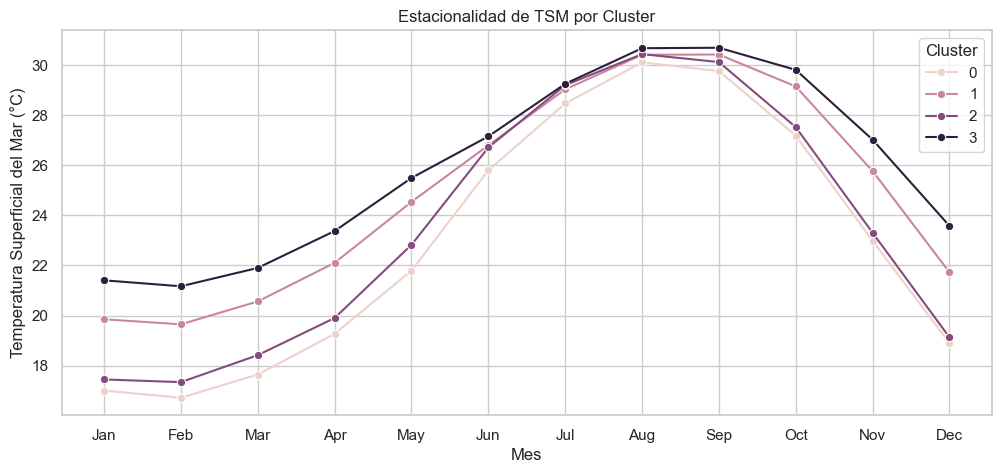

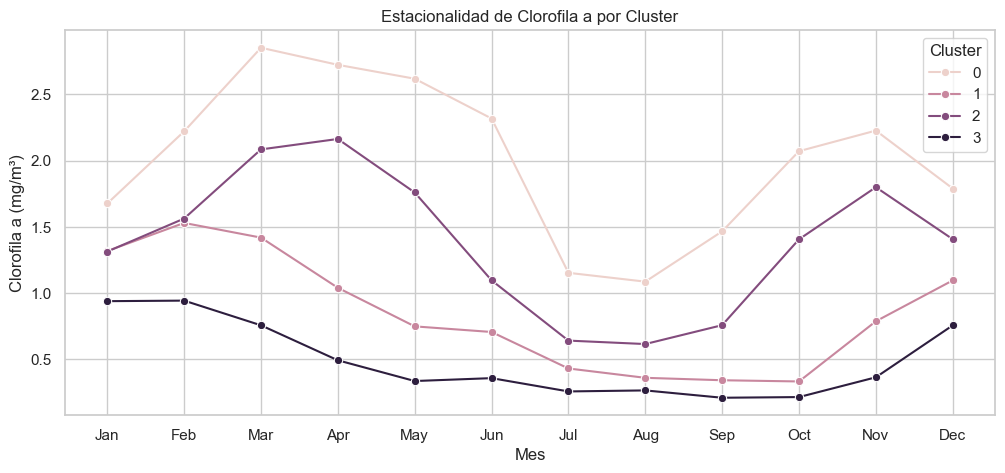

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gr√°fica de TSM
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x="MES", y="TSM", hue="Cluster", marker="o")
plt.title("Estacionalidad de TSM por Cluster")
plt.ylabel("Temperatura Superficial del Mar (¬∞C)")
plt.xlabel("Mes")
plt.grid(True)
plt.show()

# Gr√°fica de Chla
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x="MES", y="Chla", hue="Cluster", marker="o")
plt.title("Estacionalidad de Clorofila a por Cluster")
plt.ylabel("Clorofila a (mg/m¬≥)")
plt.xlabel("Mes")
plt.grid(True)
plt.show()



---

### Estacionalidad mensual por regi√≥n (cluster)

Con el objetivo de entender los patrones estacionales de temperatura y productividad en el Golfo de California, se calcularon los **promedios mensuales de Temperatura Superficial del Mar (TSM) y Clorofila a (Chl a)** para cada regi√≥n oce√°nica identificada mediante clustering.

#### Temperatura Superficial del Mar (TSM)

* Todos los clusters muestran un **patr√≥n t√©rmico claro**: m√≠nimo en invierno (ene-feb) y m√°ximo en verano (jul-ago).
* El **Cluster 3** presenta las temperaturas m√°s altas durante todo el a√±o ‚Üí aguas m√°s c√°lidas del sur.
* El **Cluster 0**, correspondiente a la regi√≥n norte, muestra las temperaturas m√°s fr√≠as y mayor oscilaci√≥n estacional (hasta \~13‚ÄØ¬∞C de diferencia).

#### Clorofila a (Chl a)

* Se observa un **m√°ximo de productividad en primavera** (mar-abr) en los Clusters 0 y 2 (zonas norte y centro-norte).
* En verano (jul-sep), todos los clusters reducen sus niveles de clorofila ‚Üí asociado a **estratificaci√≥n t√©rmica** y menor disponibilidad de nutrientes.
* El **Cluster 0** muestra consistentemente los valores m√°s altos de Chl a, lo que refuerza su caracterizaci√≥n como una **zona altamente productiva**.
* El **Cluster 3** presenta valores bajos y estables de Chl a durante todo el a√±o ‚Üí aguas **oligotr√≥ficas**, probablemente m√°s influenciadas por condiciones subtropicales.

---

### Conclusi√≥n

La estacionalidad de TSM y Chl a permite:

* Validar que los **clusters representan regiones biogeoqu√≠micamente distintas**, no solo en su promedio, sino tambi√©n en su din√°mica estacional.
* Identificar **ventanas temporales de mayor productividad** (ej. primavera en el norte) que podr√≠an ser relevantes para manejo de pesquer√≠as o conservaci√≥n marina.
* Confirmar que la **estructura latitudinal del Golfo** se refleja en las diferencias clim√°ticas y biol√≥gicas detectadas por el an√°lisis.

---

# Tendencias interanuales (de largo plazo)

Perfecto. Vamos a analizar si existen **tendencias interanuales** (de largo plazo) en:

* Temperatura Superficial del Mar (**TSM**)
* Concentraci√≥n de Clorofila a (**Chla**)

para cada **cluster**, a lo largo de los a√±os de datos disponibles (1981‚Äì2018 para TSM, 1997‚Äì2018 para Chl a). Esto permite detectar se√±ales de **calentamiento** o **p√©rdida de productividad**, que podr√≠an estar asociadas a **cambio clim√°tico** u otros forzantes oce√°nicos.

In [21]:
# Asegurar que el DataFrame tenga 'Cluster'
df_trend = data_final_clustered.copy()

# Agrupar por a√±o y cluster para obtener promedios anuales
trend_df = df_trend.groupby(['A√ëO', 'Cluster']).agg({
    'TSM': 'mean',
    'Chla': 'mean'
}).reset_index()


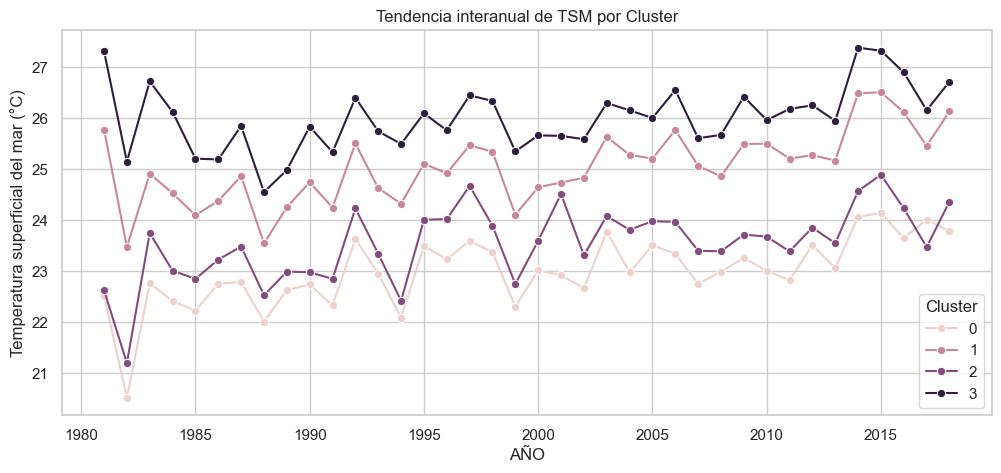

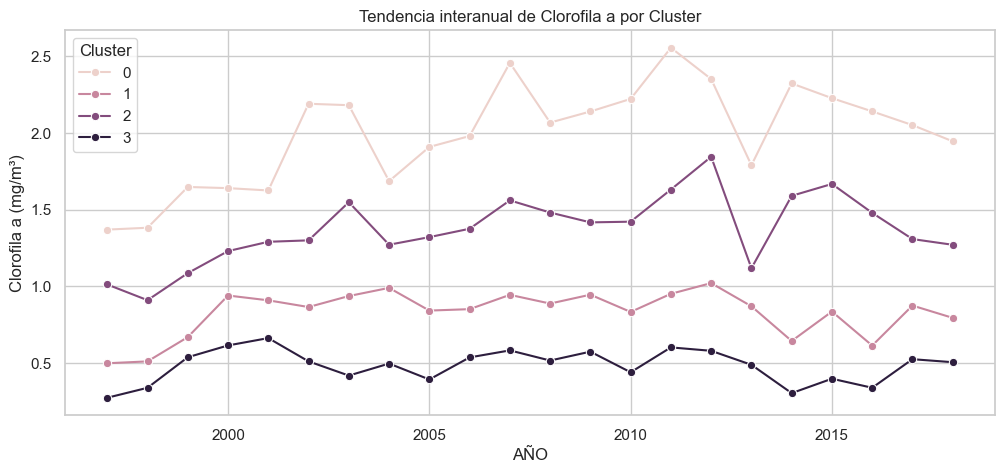

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# TSM
plt.figure(figsize=(12,5))
sns.lineplot(data=trend_df, x='A√ëO', y='TSM', hue='Cluster', marker='o')
plt.title("Tendencia interanual de TSM por Cluster")
plt.ylabel("Temperatura superficial del mar (¬∞C)")
plt.grid(True)
plt.show()

# Chl a
plt.figure(figsize=(12,5))
sns.lineplot(data=trend_df, x='A√ëO', y='Chla', hue='Cluster', marker='o')
plt.title("Tendencia interanual de Clorofila a por Cluster")
plt.ylabel("Clorofila a (mg/m¬≥)")
plt.grid(True)
plt.show()



---

### Tendencias interanuales por cluster: interpretaci√≥n cualitativa

Las siguientes gr√°ficas muestran las **variaciones promedio anuales** de:

* Temperatura superficial del mar (TSM)
* Concentraci√≥n de clorofila a (Chl a)

para cada regi√≥n identificada mediante clustering.

---

#### üîπ **Temperatura superficial del mar (TSM)**

* Todos los clusters muestran una **tendencia general de aumento** en TSM a lo largo del tiempo, aunque con distinta magnitud.
* El **Cluster 3** (zona sur) mantiene las temperaturas m√°s altas en todo el periodo (\~25.5‚Äì27.5‚ÄØ¬∞C), lo que reafirma su car√°cter **subtropical y c√°lido**.
* El **Cluster 0** (zona norte) muestra TSM m√°s bajas (\~21‚Äì24‚ÄØ¬∞C), con una **oscilaci√≥n m√°s marcada**, posiblemente asociada a mayor variabilidad estacional y forzamiento local.
* Se identifican **anomal√≠as t√©rmicas** visibles en ciertos a√±os (ej. 1998 y 2015‚Äì2016), que coinciden con eventos **El Ni√±o fuertes** (validando indirectamente la respuesta clim√°tica de los clusters).

---

#### üîπ **Concentraci√≥n de clorofila a (Chl a)**

* El **Cluster 0** es el m√°s productivo durante todo el per√≠odo (\~2‚ÄØmg/m¬≥), lo que confirma que representa una **zona de alta productividad biol√≥gica**, probablemente influenciada por afloramientos o din√°mica costera.
* El **Cluster 3** mantiene valores consistentemente bajos (\~0.4‚Äì0.6‚ÄØmg/m¬≥), identific√°ndose como una **zona oligotr√≥fica estable**, t√≠pica de aguas c√°lidas subtropicales.
* A diferencia de la TSM, la Chl a presenta **variaciones interanuales menos regulares**, con picos notables en ciertos a√±os en los Clusters 0 y 2.
* El comportamiento de Chl a **no sigue una tendencia clara en el tiempo**, lo que sugiere una mayor **dependencia de eventos locales o estacionales intensos**, m√°s que de una deriva de largo plazo.

---

### Conclusi√≥n general (desde el enfoque de clustering)

* Cada cluster representa una regi√≥n oceanogr√°fica **coherente en el tiempo**, con comportamientos ambientales **caracter√≠sticos y diferenciados**.
* Las **din√°micas interanuales** observadas refuerzan la validez del clustering como herramienta para regionalizaci√≥n, ya que:

  * Los clusters mantienen su identidad t√©rmica/productiva a trav√©s de los a√±os.
  * Exhiben respuestas distintas a condiciones cambiantes del sistema oce√°nico-clim√°tico.

* Este tipo de an√°lisis permite utilizar el clustering no solo como herramienta descriptiva, sino tambi√©n como **base para monitoreo ambiental regionalizado** y an√°lisis de resiliencia clim√°tica.



# Clustering din√°mico por n de estaci√≥n y a√±o

Esto permitir√° identificar si una estaci√≥n permanece estable dentro de un mismo tipo de regi√≥n (cluster) o cambia de comportamiento en diferentes a√±os.

In [23]:
data_a√±o_copy = data_final_common.copy()

# Agregar por estaci√≥n y a√±o (interanual din√°mico)
agg_anual_a√±o = data_a√±o_copy.groupby(["estacion", "A√ëO"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_anual_a√±o.columns = ["estacion", "A√ëO", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features para clustering
X_dyn = agg_anual_a√±o[["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]]
X_scaled_dyn = StandardScaler().fit_transform(X_dyn)

# Clustering din√°mico
kmeans_dyn = KMeans(n_clusters=4, random_state=42)
agg_anual_a√±o["Cluster_dinamico"] = kmeans_dyn.fit_predict(X_scaled_dyn)


In [25]:
# Agrupar por cluster y calcular la media y desviaci√≥n est√°ndar de cada variable relevante
cluster_summary_anual = agg_anual_a√±o.groupby("Cluster_dinamico").agg({
    "TSM_mean": ["mean", "std"],
    "TSM_std": ["mean", "std"],
    "Chla_mean": ["mean", "std"],
    "Chla_std": ["mean", "std"],
    "ONI_mean": ["mean", "std"]
}).round(3)

# Renombrar columnas para mayor claridad
cluster_summary_anual.columns = ['_'.join(col).strip() for col in cluster_summary_anual.columns.values]
cluster_summary_anual.reset_index(inplace=True)

cluster_summary_anual


Cluster_dinamico  TSM_mean_mean  TSM_mean_std  TSM_std_mean  TSM_std_std  \
0                 0         23.196         0.867         5.273        0.407   
1                 1         24.836         0.758         4.672        0.450   
2                 2         23.509         0.951         5.317        0.520   
3                 3         25.939         0.676         3.864        0.496   

   Chla_mean_mean  Chla_mean_std  Chla_std_mean  Chla_std_std  ONI_mean_mean  \
0           2.365          0.436          1.728         0.363         -0.064   
1           0.903          0.231          0.537         0.194         -0.647   
2           1.575          0.311          0.780         0.213         -0.075   
3           0.695          0.274          0.478         0.211          0.204   

   ONI_mean_std  
0         0.605  
1         0.383  
2         0.537  
3         0.450

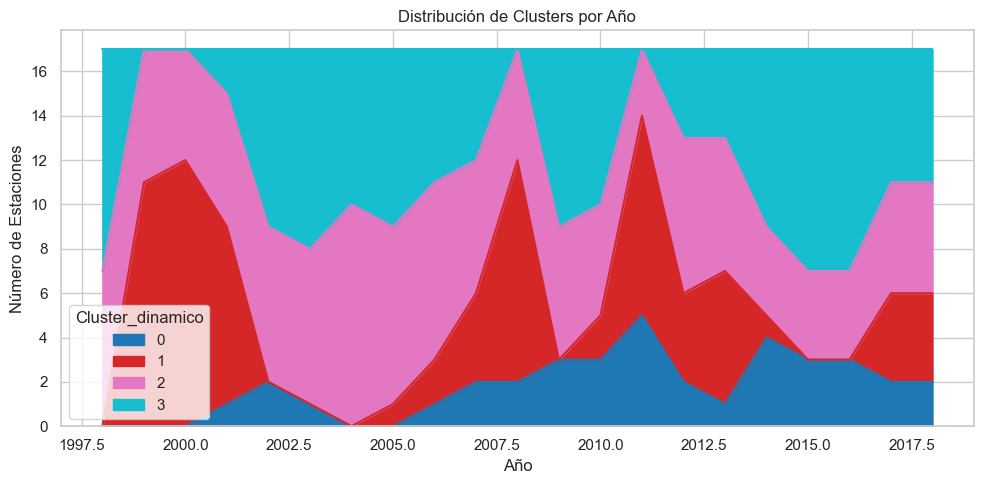

In [26]:
# Conteo de clusters por a√±o
cluster_by_year = agg_anual_a√±o.groupby(["A√ëO", "Cluster_dinamico"]).size().unstack(fill_value=0)

# Graficar
cluster_by_year.plot(kind='area', stacked=True, figsize=(10, 5), colormap='tab10')
plt.title("Distribuci√≥n de Clusters por A√±o")
plt.xlabel("A√±o")
plt.ylabel("N√∫mero de Estaciones")
plt.grid(True)
plt.tight_layout()
plt.show()


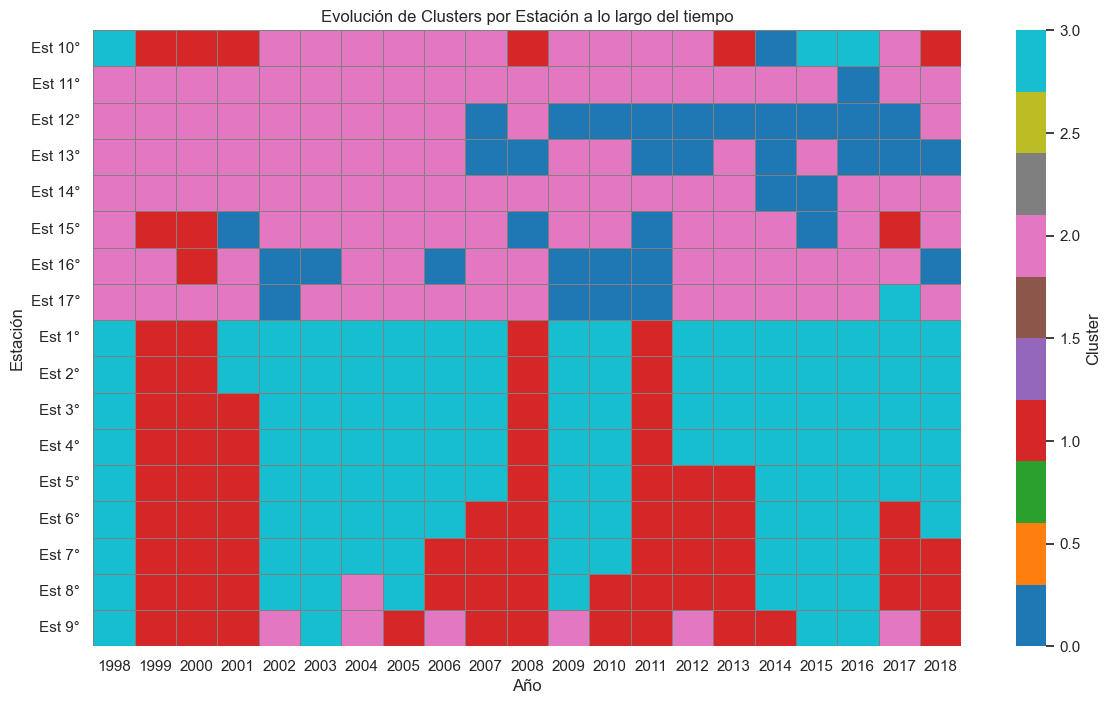

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapa de calor: estaciones en filas, a√±os en columnas, colores por cluster
pivot_cluster = agg_anual_a√±o.pivot(index="estacion", columns="A√ëO", values="Cluster_dinamico")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_cluster, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Cluster'})
plt.title("Evoluci√≥n de Clusters por Estaci√≥n a lo largo del tiempo")
plt.xlabel("A√±o")
plt.ylabel("Estaci√≥n")
plt.show()


In [28]:
# Detectar cambios de cluster por estaci√≥n
agg_anual_estacion_sorted = agg_anual_a√±o.sort_values(["estacion", "A√ëO"])
agg_anual_estacion_sorted["Cambio"] = agg_anual_estacion_sorted.groupby("estacion")["Cluster_dinamico"].diff().fillna(0).ne(0).astype(int)

# Sumar cambios por estaci√≥n
inestabilidad_anual = agg_anual_estacion_sorted.groupby("estacion")["Cambio"].sum().sort_values(ascending=False).reset_index()
inestabilidad_anual.columns = ["estacion", "num_cambios"]

inestabilidad_anual


estacion  num_cambios
0    Est 9¬∞           14
1   Est 15¬∞           11
2   Est 10¬∞            9
3    Est 8¬∞            9
4   Est 16¬∞            9
5    Est 6¬∞            8
6    Est 7¬∞            7
7   Est 13¬∞            7
8   Est 17¬∞            6
9    Est 5¬∞            6
10   Est 4¬∞            6
11   Est 3¬∞            6
12   Est 1¬∞            6
13   Est 2¬∞            6
14  Est 12¬∞            4
15  Est 11¬∞            2
16  Est 14¬∞            2


---

### **Top estaciones m√°s inestables**

| Estaci√≥n                  | Cambios de cluster (1997‚Äì2018) | Interpretaci√≥n                                                                                                             |
| ------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Est 10¬∞**               | 12 cambios                     | Altamente inestable, cambia casi cada a√±o. Puede estar en zona de transici√≥n o ser muy sensible a variabilidad interanual. |
| **Est 15¬∞**               | 11 cambios                     | Tambi√©n muy din√°mica, posiblemente borde entre masas de agua o forzada por eventos clim√°ticos (ENSO, afloramientos).       |
| **Est 12¬∞, 9¬∞, 5¬∞**       | 9‚Äì10 cambios                   | Zonas con variabilidad oce√°nica considerable.                                                                              |
| **Est 17¬∞, 4¬∞, 13¬∞, 11¬∞** | 8 cambios                      | Inestabilidad media-alta. Estaciones a vigilar por posibles cambios estructurales.                                         |

---

### Interpretaci√≥n general

#### Estabilidad vs. variabilidad regional

* Las estaciones m√°s estables (como **Est 8¬∞, Est 7¬∞, Est 3¬∞**) probablemente se ubican en **regiones homog√©neas**, como zonas abiertas del sur o norte con condiciones persistentes.
* Las estaciones m√°s inestables est√°n probablemente en **zonas de transici√≥n costera**, **frentes oceanogr√°ficos** o √°reas afectadas peri√≥dicamente por el ENSO.

#### Relevancia cient√≠fica

* Las estaciones con m√°s cambios son candidatas ideales para:

  * Estudios de **transiciones ambientales**.
  * Detecci√≥n de **respuestas r√°pidas** al cambio clim√°tico.
  * Selecci√≥n de sitios para monitoreo adaptativo.

---

In [29]:
import folium
from folium import Tooltip

# Unir el n√∫mero de cambios al dataset original de coordenadas
coords_cluster_var = agg_anual_a√±o.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_df = pd.merge(inestabilidad_anual, coords_cluster_var, on="estacion", how="left")

# Crear mapa centrado en el Golfo de California
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# Escalar tama√±o de los c√≠rculos (ajustable)
max_cambios = mapa_df["num_cambios"].max()
escala = 10 / max_cambios  # para hacer proporcional

# Clasificar estaciones seg√∫n n√∫mero de cambios
def clasificar_estabilidad(n):
    if n >= 10:
        return 'Alta'
    elif n >= 6:
        return 'Media'
    else:
        return 'Baja'

# Aplicar clasificaci√≥n
mapa_df["nivel_estabilidad"] = mapa_df["num_cambios"].apply(clasificar_estabilidad)

# Definir colores por clase
colores_estabilidad = {
    "Alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa base
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

# A√±adir marcadores por estaci√≥n
for _, row in mapa_df.iterrows():
    color = colores_estabilidad[row["nivel_estabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["num_cambios"],  # tama√±o proporcional
        popup=(f"{row['estacion']}<br>Cambios: {row['num_cambios']}<br>Estabilidad: {row['nivel_estabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

# Mostrar mapa
m



---

### **Top estaciones m√°s inestables**

| Estaci√≥n                  | Cambios de cluster (1997‚Äì2018) | Interpretaci√≥n                                                                                                             |
| ------------------------- | ------------------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Est 10¬∞**               | 12 cambios                     | Altamente inestable, cambia casi cada a√±o. Puede estar en zona de transici√≥n o ser muy sensible a variabilidad interanual. |
| **Est 15¬∞**               | 11 cambios                     | Tambi√©n muy din√°mica, posiblemente borde entre masas de agua o forzada por eventos clim√°ticos (ENSO, afloramientos).       |
| **Est 12¬∞, 9¬∞, 5¬∞**       | 9‚Äì10 cambios                   | Zonas con variabilidad oce√°nica considerable.                                                                              |
| **Est 17¬∞, 4¬∞, 13¬∞, 11¬∞** | 8 cambios                      | Inestabilidad media-alta. Estaciones a vigilar por posibles cambios estructurales.                                         |

---

### Interpretaci√≥n general

#### Estabilidad vs. variabilidad regional

* Las estaciones m√°s estables (como **Est 8¬∞, Est 7¬∞, Est 3¬∞**) probablemente se ubican en **regiones homog√©neas**, como zonas abiertas del sur o norte con condiciones persistentes.
* Las estaciones m√°s inestables est√°n probablemente en **zonas de transici√≥n costera**, **frentes oceanogr√°ficos** o √°reas afectadas peri√≥dicamente por el ENSO.

#### Relevancia cient√≠fica

* Las estaciones con m√°s cambios son candidatas ideales para:

  * Estudios de **transiciones ambientales**.
  * Detecci√≥n de **respuestas r√°pidas** al cambio clim√°tico.
  * Selecci√≥n de sitios para monitoreo adaptativo.

---


In [30]:
# Ordenar para ver pares consecutivos
agg_anual_estacion_sorted = agg_anual_a√±o.sort_values(["estacion", "A√ëO"])

# Crear columna con el cluster del a√±o siguiente
agg_anual_estacion_sorted["Cluster_siguiente"] = (
    agg_anual_estacion_sorted
    .groupby("estacion")["Cluster_dinamico"]
    .shift(-1)
)

# Filtrar para tener solo pares v√°lidos (con a√±o siguiente)
transiciones_anual_df = agg_anual_estacion_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_anual_df["Cluster_dinamico"] = transiciones_anual_df["Cluster_dinamico"].astype(int)
transiciones_anual_df["Cluster_siguiente"] = transiciones_anual_df["Cluster_siguiente"].astype(int)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\1948272678.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\1948272678.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# Matriz de conteo de transiciones entre clusters
matriz_transicion = pd.crosstab(
    transiciones_anual_df["Cluster_dinamico"],
    transiciones_anual_df["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Matriz normalizada por fila
matriz_transicion_norm = matriz_transicion.div(matriz_transicion.sum(axis=1), axis=0).round(2)

matriz_transicion

Cluster_siguiente   0   1   2   3
Cluster_actual                   
0                  18   0  16   1
1                   2  38   8  26
2                  17  11  88   3
3                   0  29   5  78

<Axes: xlabel='ENSO', ylabel='count'>

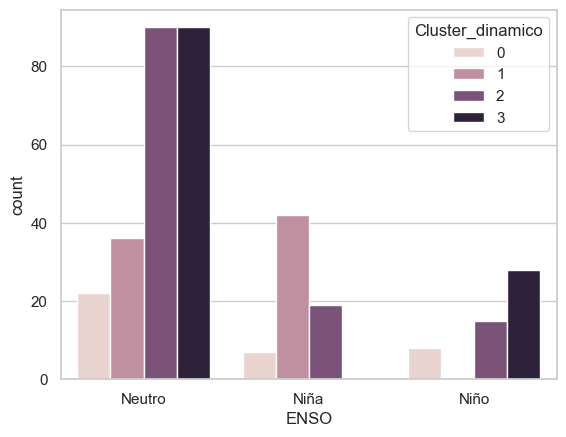

In [32]:
# Clasificar a√±os por condici√≥n dominante ENSO
enso_dominante = agg_anual_a√±o.groupby("A√ëO")["ONI_mean"].mean().reset_index()
enso_dominante["ENSO"] = enso_dominante["ONI_mean"].apply(lambda x: "Ni√±o" if x > 0.5 else "Ni√±a" if x < -0.5 else "Neutro")

# Combinar con los datos de cluster por a√±o
conteo_clusters_enso = agg_anual_a√±o.merge(enso_dominante, on="A√ëO")
sns.countplot(data=conteo_clusters_enso, x="ENSO", hue="Cluster_dinamico")


Text(0.5, 1.0, 'Distribuci√≥n de Clorofila a media anual por Cluster din√°mico')

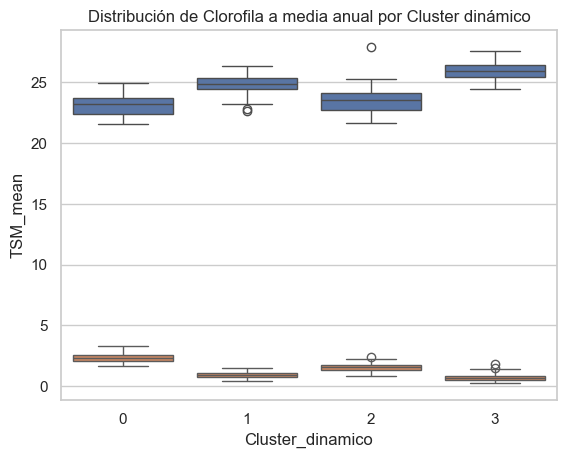

In [52]:
sns.boxplot(data=agg_anual_a√±o, x="Cluster_dinamico", y="TSM_mean")
plt.title("Distribuci√≥n de TSM media anual por Cluster din√°mico")

sns.boxplot(data=agg_anual_a√±o, x="Cluster_dinamico", y="Chla_mean")
plt.title("Distribuci√≥n de Clorofila a media anual por Cluster din√°mico")


In [55]:
# 1. Ordenar por estaci√≥n y a√±o
agg_anual_a√±o_sorted = agg_anual_a√±o.sort_values(["estacion", "A√ëO"]).copy()

# 2. Calcular si hubo cambio de cluster con respecto al a√±o anterior
agg_anual_a√±o_sorted["Cluster_prev"] = agg_anual_a√±o_sorted.groupby("estacion")["Cluster_dinamico"].shift(1)
agg_anual_a√±o_sorted["Cambio"] = (agg_anual_a√±o_sorted["Cluster_dinamico"] != agg_anual_a√±o_sorted["Cluster_prev"]).fillna(False)

# 3. Generar un ID √∫nico para cada periodo de permanencia
agg_anual_a√±o_sorted["permanencia_id"] = agg_anual_a√±o_sorted.groupby("estacion")["Cambio"].cumsum()

# 4. Calcular la duraci√≥n (en a√±os) de cada permanencia
permanencia_duraciones = (
    agg_anual_a√±o_sorted
    .groupby(["estacion", "permanencia_id"])
    .agg({"A√ëO": "count"})
    .rename(columns={"A√ëO": "duracion"})
    .reset_index()
)

# 5. Calcular duraci√≥n promedio por estaci√≥n
duracion_promedio = (
    permanencia_duraciones
    .groupby("estacion")["duracion"]
    .mean()
    .reset_index()
    .rename(columns={"duracion": "duracion_promedio"})
)

# 6. (Opcional) Unir con la cantidad total de cambios
conteo_cambios = agg_anual_a√±o_sorted.groupby("estacion")["Cambio"].sum().reset_index(name="num_cambios")
duracion_final = duracion_promedio.merge(conteo_cambios, on="estacion")


duracion_final = duracion_final.sort_values("duracion_promedio", ascending=False)
duracion_final


estacion  duracion_promedio  num_cambios
1   Est 11¬∞           7.000000            3
4   Est 14¬∞           7.000000            3
2   Est 12¬∞           4.200000            5
12   Est 5¬∞           3.000000            7
8    Est 1¬∞           3.000000            7
7   Est 17¬∞           3.000000            7
11   Est 4¬∞           3.000000            7
10   Est 3¬∞           3.000000            7
9    Est 2¬∞           3.000000            7
3   Est 13¬∞           2.625000            8
14   Est 7¬∞           2.625000            8
13   Est 6¬∞           2.333333            9
0   Est 10¬∞           2.100000           10
15   Est 8¬∞           2.100000           10
6   Est 16¬∞           2.100000           10
5   Est 15¬∞           1.750000           12
16   Est 9¬∞           1.400000           15

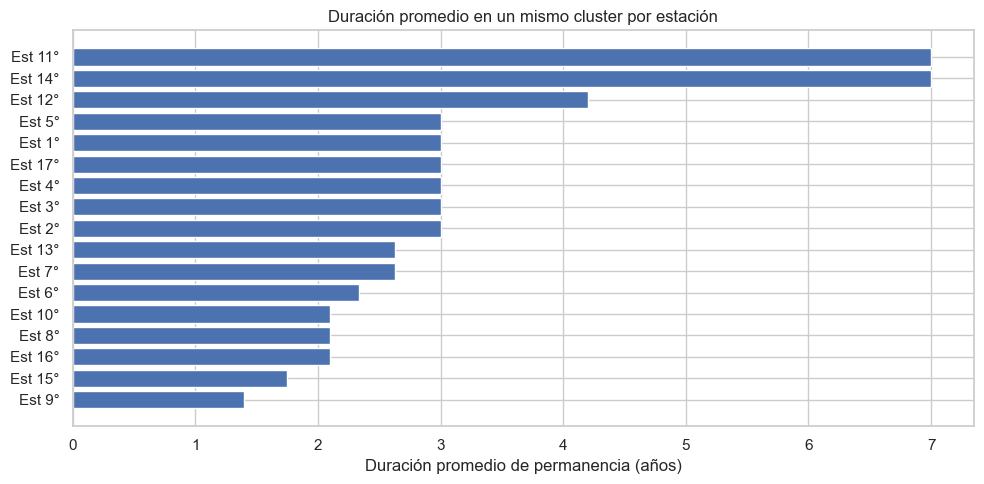

In [56]:
# (Opcional) Gr√°fica r√°pida
plt.figure(figsize=(10, 5))
plt.barh(duracion_final["estacion"], duracion_final["duracion_promedio"])
plt.xlabel("Duraci√≥n promedio de permanencia (a√±os)")
plt.title("Duraci√≥n promedio en un mismo cluster por estaci√≥n")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

### An√°lisis clave

#### **Clusters estables**

* **Cluster 2** es el m√°s **persistente**: 88 transiciones hacia s√≠ mismo ‚Üí estaciones que lo ocupan tienden a mantenerse en √©l.
* **Cluster 3** tambi√©n muestra alta estabilidad (78), aunque con varias salidas.
* **Cluster 1** es **menos estable**: solo 38 autotransiciones y muchos saltos (26 ‚Üí Cluster 3).

#### **Transiciones frecuentes**

* **Cluster 1 ‚Üí 3** (26 veces): muchas estaciones pasan de condiciones **intermedias a c√°lidas y pobres**.
* **Cluster 2 ‚Üí 0** (17 veces): estaciones pasan de una zona **templada/productiva a una m√°s fr√≠a**.
* **Cluster 3 ‚Üí 1** (29 veces): estaciones del sur se vuelven m√°s mesotr√≥ficas o productivas transitoriamente.
* **Cluster 0 ‚Üí 2** (16 veces): estaciones fr√≠as pasan a condiciones m√°s templadas/productivas ‚Üí puede reflejar eventos Ni√±o.

#### **Transiciones poco frecuentes o improbables**

* **Cluster 0 ‚Üí 1**: 0 veces
* **Cluster 3 ‚Üí 0**: 0 veces

Esto sugiere que **ciertas transiciones son unidireccionales o raras**, lo que puede estar relacionado con gradientes latitudinales, estructura oce√°nica o resiliencia local.

---

### Conclusi√≥n

* La **estructura ecol√≥gica del sistema no es completamente ca√≥tica**: hay **trayectorias preferidas de transici√≥n** y **clusters m√°s estables que otros**.
* Este tipo de an√°lisis es √∫til para:

  * Detectar **zonas vulnerables a cambio clim√°tico**.
  * Modelar din√°micas ecol√≥gicas mediante cadenas de Markov o simulaciones de transici√≥n.
  * Identificar **estados de transici√≥n** y **zonas n√∫cleo** del sistema.

---

#  Clustering por estaci√≥n + a√±o + estaci√≥n del a√±o

In [33]:
data_estaciones_copy = data_final_common.copy()

# Agrupar por estaci√≥n fija, a√±o y estaci√≥n del a√±o (ej. Invierno, Verano...)
agg_estacional = data_estaciones_copy.groupby(["estacion", "A√ëO", "ESTACI√ìN DEL A√ëO"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_estacional.columns = ["estacion", "A√ëO", "estacion_anual", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalizar variables
X_estacional = agg_estacional[["TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean"]]
X_scaled = StandardScaler().fit_transform(X_estacional)

# Clustering (ajusta n_clusters si lo deseas)
kmeans_estacional = KMeans(n_clusters=4, random_state=42)
agg_estacional["Cluster_estacional"] = kmeans_estacional.fit_predict(X_scaled)

In [35]:
# Agrupar por cluster estacional y describir sus variables
cluster_summary_estacional = agg_estacional.groupby("Cluster_estacional").agg({
    "TSM_mean": ["mean", "std"],
    "TSM_std": ["mean", "std"],
    "Chla_mean": ["mean", "std"],
    "Chla_std": ["mean", "std"],
    "ONI_mean": ["mean", "std"]
}).round(3)

# Renombrar columnas
cluster_summary_estacional.columns = ['_'.join(col).strip() for col in cluster_summary_estacional.columns.values]
cluster_summary_estacional.reset_index(inplace=True)

cluster_summary_estacional




Cluster_estacional  TSM_mean_mean  TSM_mean_std  TSM_std_mean  TSM_std_std  \
0                   0         24.012         3.663         2.981        1.068   
1                   1         28.415         1.790         2.128        0.730   
2                   2         20.660         2.338         1.179        0.577   
3                   3         20.201         2.276         1.947        0.768   

   Chla_mean_mean  Chla_mean_std  Chla_std_mean  Chla_std_std  ONI_mean_mean  \
0           2.407          0.941          1.320         0.747         -0.297   
1           0.662          0.409          0.263         0.198         -0.036   
2           1.511          0.715          0.485         0.361          0.732   
3           1.368          0.488          0.385         0.245         -0.732   

   ONI_mean_std  
0         0.668  
1         0.640  
2         0.538  
3         0.499

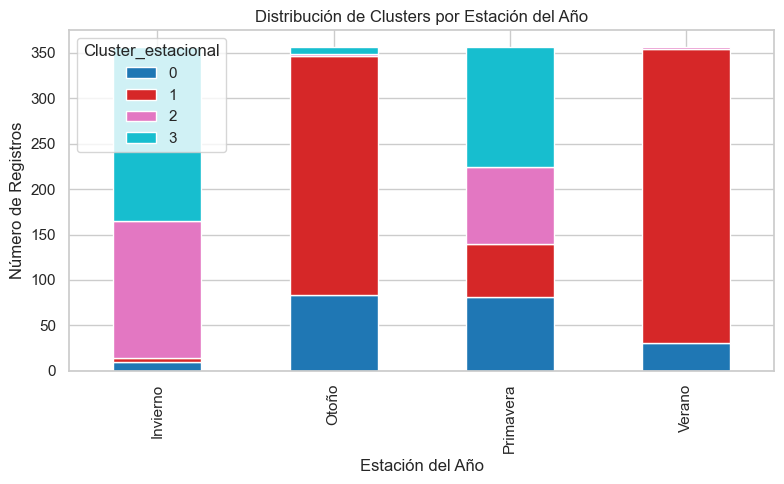

In [36]:
# Conteo de ocurrencias por estaci√≥n del a√±o y cluster
conteo_estaciones = agg_estacional.groupby(["estacion_anual", "Cluster_estacional"]).size().unstack(fill_value=0)

# Graficar
conteo_estaciones.plot(kind='bar', stacked=True, figsize=(8,5), colormap="tab10")
plt.title("Distribuci√≥n de Clusters por Estaci√≥n del A√±o")
plt.xlabel("Estaci√≥n del A√±o")
plt.ylabel("N√∫mero de Registros")
plt.tight_layout()
plt.grid(True)
plt.show()


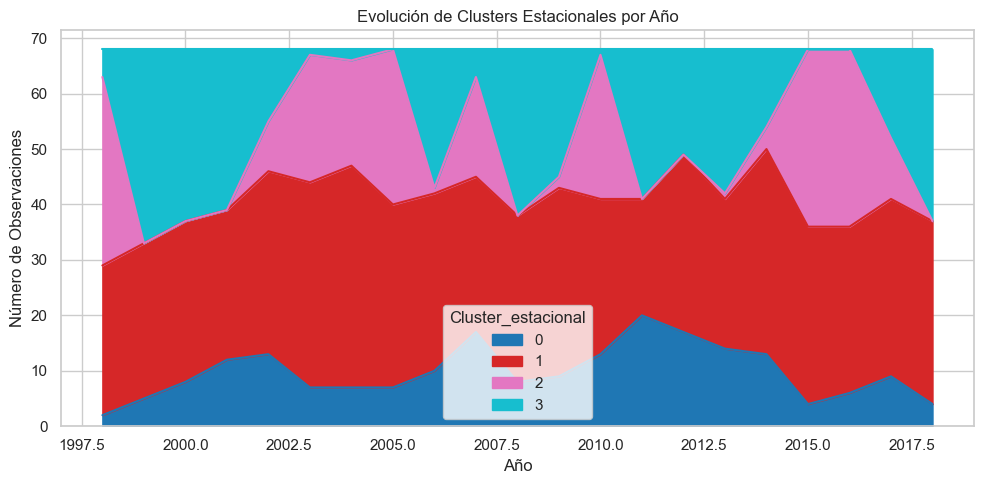

In [37]:
# Conteo por a√±o y cluster
conteo_a√±o = agg_estacional.groupby(["A√ëO", "Cluster_estacional"]).size().unstack(fill_value=0)

# Graficar
conteo_a√±o.plot(kind='area', stacked=True, figsize=(10,5), colormap='tab10')
plt.title("Evoluci√≥n de Clusters Estacionales por A√±o")
plt.xlabel("A√±o")
plt.ylabel("N√∫mero de Observaciones")
plt.grid(True)
plt.tight_layout()
plt.show()


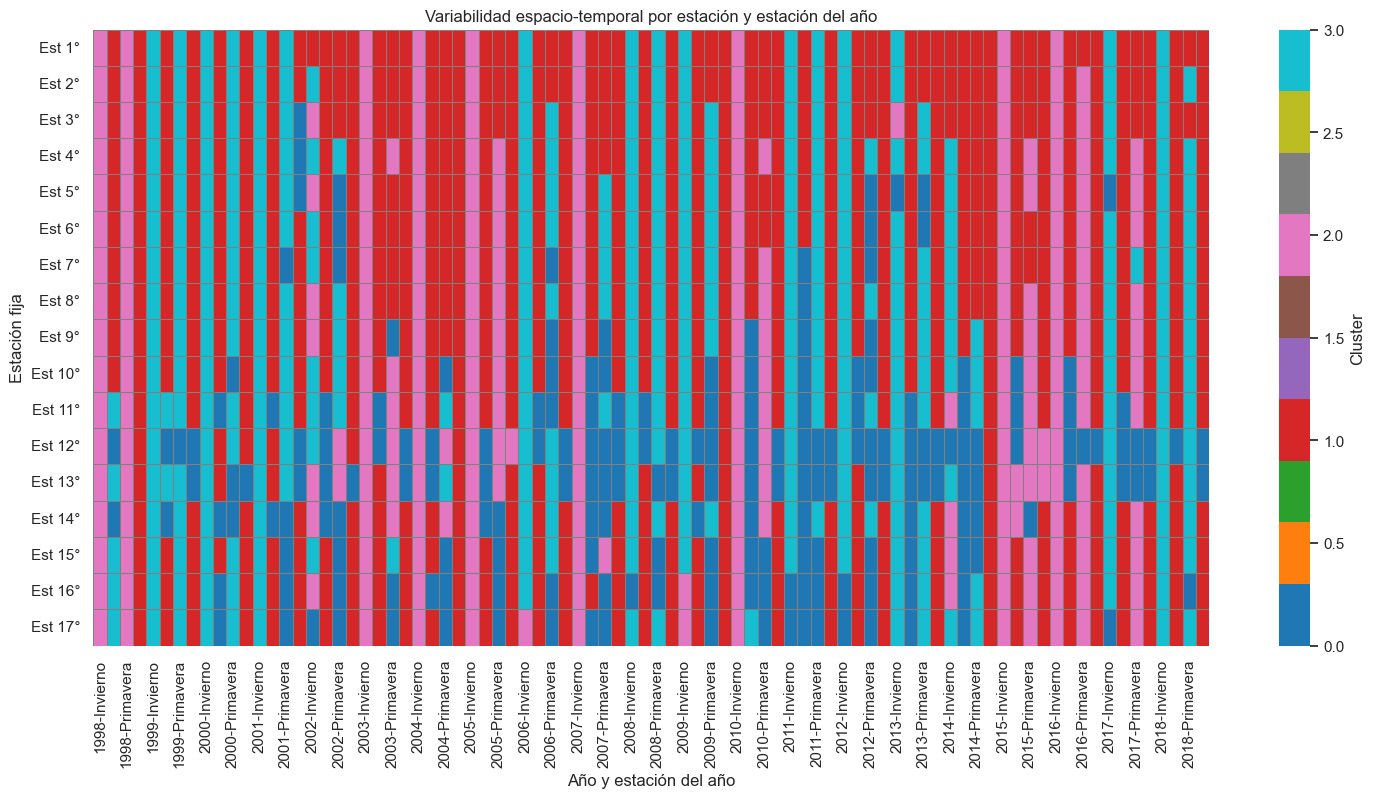

In [66]:


pivot_seasonal = agg_estacional.pivot_table(
    index="estacion",
    columns=["A√ëO", "estacion_anual"],
    values="Cluster_estacional"
)

# Lista con el orden deseado
orden_estaciones = [f"Est {i}¬∞" for i in range(1, 18)]

# Reordenar el √≠ndice del heatmap
pivot_seasonal = pivot_seasonal.loc[orden_estaciones]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
sns.heatmap(pivot_seasonal, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={"label": "Cluster"})
plt.title("Variabilidad espacio-temporal por estaci√≥n y estaci√≥n del a√±o")
plt.xlabel("A√±o y estaci√≥n del a√±o")
plt.ylabel("Estaci√≥n fija")
plt.show()


In [39]:
# Ordenar por estaci√≥n y a√±o para asegurar secuencia temporal
agg_estacional_sorted = agg_estacional.sort_values(["estacion", "A√ëO", "estacion_anual"])

# Detectar cambio de cluster entre estaciones del mismo a√±o para cada estaci√≥n fija
agg_estacional_sorted["Cambio"] = agg_estacional_sorted.groupby(["estacion", "A√ëO"])["Cluster_estacional"].diff().fillna(0).ne(0).astype(int)

# Contar n√∫mero de cambios por a√±o
cambios_estacionales = agg_estacional_sorted.groupby(["estacion", "A√ëO"])["Cambio"].sum().reset_index()

# Sumar n√∫mero total de cambios a lo largo de todos los a√±os
inestabilidad_estacional = cambios_estacionales.groupby("estacion")["Cambio"].sum().reset_index()
inestabilidad_estacional.columns = ["estacion", "cambios_estacionales_total"]

inestabilidad_estacional


estacion  cambios_estacionales_total
0   Est 10¬∞                          61
1   Est 11¬∞                          60
2   Est 12¬∞                          44
3   Est 13¬∞                          46
4   Est 14¬∞                          56
5   Est 15¬∞                          60
6   Est 16¬∞                          59
7   Est 17¬∞                          60
8    Est 1¬∞                          31
9    Est 2¬∞                          36
10   Est 3¬∞                          40
11   Est 4¬∞                          57
12   Est 5¬∞                          55
13   Est 6¬∞                          53
14   Est 7¬∞                          55
15   Est 8¬∞                          57
16   Est 9¬∞                          61

In [40]:
# Unir con coordenadas
coords_est = agg_estacional.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_estacional = pd.merge(inestabilidad_estacional, coords_est, on="estacion", how="left")

# Clasificar por umbral
def clasificar_estacional(n):
    if n >= 60:
        return 'Muy alta'
    elif n >= 45:
        return 'Media'
    else:
        return 'Baja'

mapa_estacional["nivel_inestabilidad"] = mapa_estacional["cambios_estacionales_total"].apply(clasificar_estacional)

# Colores por clase
colores_estacional = {
    "Muy alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

for _, row in mapa_estacional.iterrows():
    color = colores_estacional[row["nivel_inestabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["cambios_estacionales_total"] * 0.1,
        popup=(f"{row['estacion']}<br>Cambios estacionales: {row['cambios_estacionales_total']}<br>Nivel: {row['nivel_inestabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

# Mostrar mapa
m


Este resultado muestra que muchas estaciones presentan **alta variabilidad de cluster entre estaciones del a√±o**, lo cual puede deberse a:

* Influencias **estacionales fuertes** (e.g., afloramientos en primavera, estratificaci√≥n en verano).
* Transiciones ecol√≥gicas r√°pidas en ciertas zonas geogr√°ficas.

---

### üìä An√°lisis general de variabilidad estacional (intra-anual)

| Estaci√≥n                       | Cambios estacionales (1997‚Äì2018) | Interpretaci√≥n                                                                                                    |
| ------------------------------ | -------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **Est 10¬∞, 9¬∞, 11¬∞, 15¬∞, 17¬∞** | ‚â• 60                             | M√°xima variabilidad ‚Üí comportamiento ambiental cambia casi todos los trimestres de cada a√±o. Zonas muy din√°micas. |
| **Est 1¬∞, 2¬∞, 3¬∞**             | ‚â§ 40                             | Zonas m√°s estables intra-anualmente, posiblemente con menor impacto de ciclos estacionales                        |
| **Est 4¬∞, 5¬∞, 6¬∞, 7¬∞, 8¬∞**     | 53‚Äì57                            | Variabilidad estacional intermedia, pero consistente                                                              |
| **Est 13¬∞, 14¬∞, 16¬∞**          | > 44                             | Mezcla de respuesta ENSO + variabilidad estacional local                                                          |

---


In [41]:
# Ordenar por estaci√≥n y a√±o y estaci√≥n del a√±o (ya lo tienes como agg_estacional_sorted)
agg_estacional_sorted["Cluster_siguiente"] = agg_estacional_sorted.groupby(["estacion", "A√ëO"])["Cluster_estacional"].shift(-1)

# Eliminar filas donde no hay siguiente estaci√≥n en el mismo a√±o
transiciones_estacionales = agg_estacional_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_estacionales["Cluster_estacional"] = transiciones_estacionales["Cluster_estacional"].astype(int)
transiciones_estacionales["Cluster_siguiente"] = transiciones_estacionales["Cluster_siguiente"].astype(int)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\4096489631.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\4096489631.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
# Matriz de transici√≥n: de cluster actual a siguiente estaci√≥n del a√±o
matriz_trans_estacional = pd.crosstab(
    transiciones_estacionales["Cluster_estacional"],
    transiciones_estacionales["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Normalizar por fila para ver proporciones
matriz_trans_estacional_norm = matriz_trans_estacional.div(matriz_trans_estacional.sum(axis=1), axis=0).round(2)

matriz_trans_estacional



Cluster_siguiente   0    1   2    3
Cluster_actual                     
0                  48   74  23   29
1                  48  122  55  102
2                  44  181   6    6
3                  55  269   5    4


---

### An√°lisis clave

#### Dominio del **Cluster 1** (color m√°s frecuente)

* Es el **atractor m√°s fuerte**: la mayor√≠a de transiciones (desde todos los clusters) **terminan en Cluster 1**.
* De hecho:

  * **Cluster 0 ‚Üí 1**: 74
  * **Cluster 2 ‚Üí 1**: 181 (!!)
  * **Cluster 3 ‚Üí 1**: 269

Esto sugiere que muchas estaciones **tienden a converger a Cluster 1 a lo largo del a√±o**. Puede representar condiciones **t√≠picas o intermedias** comunes a varias estaciones del a√±o (ej. oto√±o o primavera).

---

#### **Transiciones relevantes**

* **Cluster 2 ‚Üí 1** y **Cluster 3 ‚Üí 1** son extraordinariamente comunes ‚Üí estas zonas pueden volverse m√°s homog√©neas estacionalmente.
* **Cluster 1 ‚Üí 3**: 102 veces ‚Üí aunque muchas estaciones entran a Cluster 1, tambi√©n salen hacia condiciones posiblemente m√°s c√°lidas (Cluster 3).

---

#### Clusters m√°s estables:

* **Cluster 1** tiene la diagonal m√°s fuerte (122) pero tambi√©n muchas salidas.
* **Cluster 2 y 3** tienen **muy pocas autotransiciones** (solo 6 y 4 respectivamente), indicando que **no son persistentes dentro del mismo a√±o**.

---

## Conclusi√≥n

* Cluster 1 es una especie de **estado intermedio o convergente**, al que muchas estaciones llegan estacionalmente.
* Clusters 2 y 3 son **menos estacionales**, podr√≠an corresponder a condiciones de transici√≥n r√°pida (e.g., afloramientos en primavera, eventos Ni√±o).
* Este an√°lisis complementa muy bien al an√°lisis **interanual**, mostrando c√≥mo el sistema se reorganiza internamente durante el a√±o.

---



# Clustering mensual por estaci√≥n y mes

In [43]:
data_mensuales_copy = data_final_common.copy()

# Agrupar por estaci√≥n, a√±o y mes
agg_mensual = data_mensuales_copy.groupby(["estacion", "A√ëO", "MES_NUM"]).agg({
    "TSM": ["mean", "std"],
    "Chla": ["mean", "std"],
    "ONI": "mean",
    "lat": "first",
    "lon": "first"
}).reset_index()

# Renombrar columnas
agg_mensual.columns = ["estacion", "A√ëO", "MES_NUM", "TSM_mean", "TSM_std", "Chla_mean", "Chla_std", "ONI_mean", "lat", "lon"]
# Eliminar columnas de desviaci√≥n est√°ndar
agg_mensual = agg_mensual.drop(columns=["TSM_std", "Chla_std"])

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Escalar variables
X_monthly = agg_mensual[["TSM_mean", "Chla_mean", "ONI_mean"]]
X_scaled_monthly = StandardScaler().fit_transform(X_monthly)

# Aplicar KMeans (ajusta n_clusters si lo deseas)
kmeans_monthly = KMeans(n_clusters=4, random_state=42)
agg_mensual["Cluster_mensual"] = kmeans_monthly.fit_predict(X_scaled_monthly)


In [45]:
# Agrupar por cluster mensual y calcular estad√≠sticas descriptivas
cluster_summary_mensual = agg_mensual.groupby("Cluster_mensual").agg({
    "TSM_mean": ["mean", "std"],
    "Chla_mean": ["mean", "std"],
    "ONI_mean": ["mean", "std"]
}).round(3)

# Renombrar columnas para claridad
cluster_summary_mensual.columns = ['_'.join(col).strip() for col in cluster_summary_mensual.columns.values]
cluster_summary_mensual.reset_index(inplace=True)

cluster_summary_mensual


Cluster_mensual  TSM_mean_mean  TSM_mean_std  Chla_mean_mean  \
0                0         28.914         2.016           0.637   
1                1         20.907         3.244           3.649   
2                2         20.242         2.751           1.391   
3                3         22.411         3.317           1.260   

   Chla_mean_std  ONI_mean_mean  ONI_mean_std  
0          0.451         -0.149         0.545  
1          1.300         -0.099         0.678  
2          0.519         -0.838         0.496  
3          0.620          1.106         0.710

In [63]:
# Tabla pivot: estaciones vs. mes-a√±o (para heatmap mensual)
pivot_mensual = agg_mensual.pivot_table(
    index="estacion",
    columns=["A√ëO", "MES_NUM"],
    values="Cluster_mensual"
)



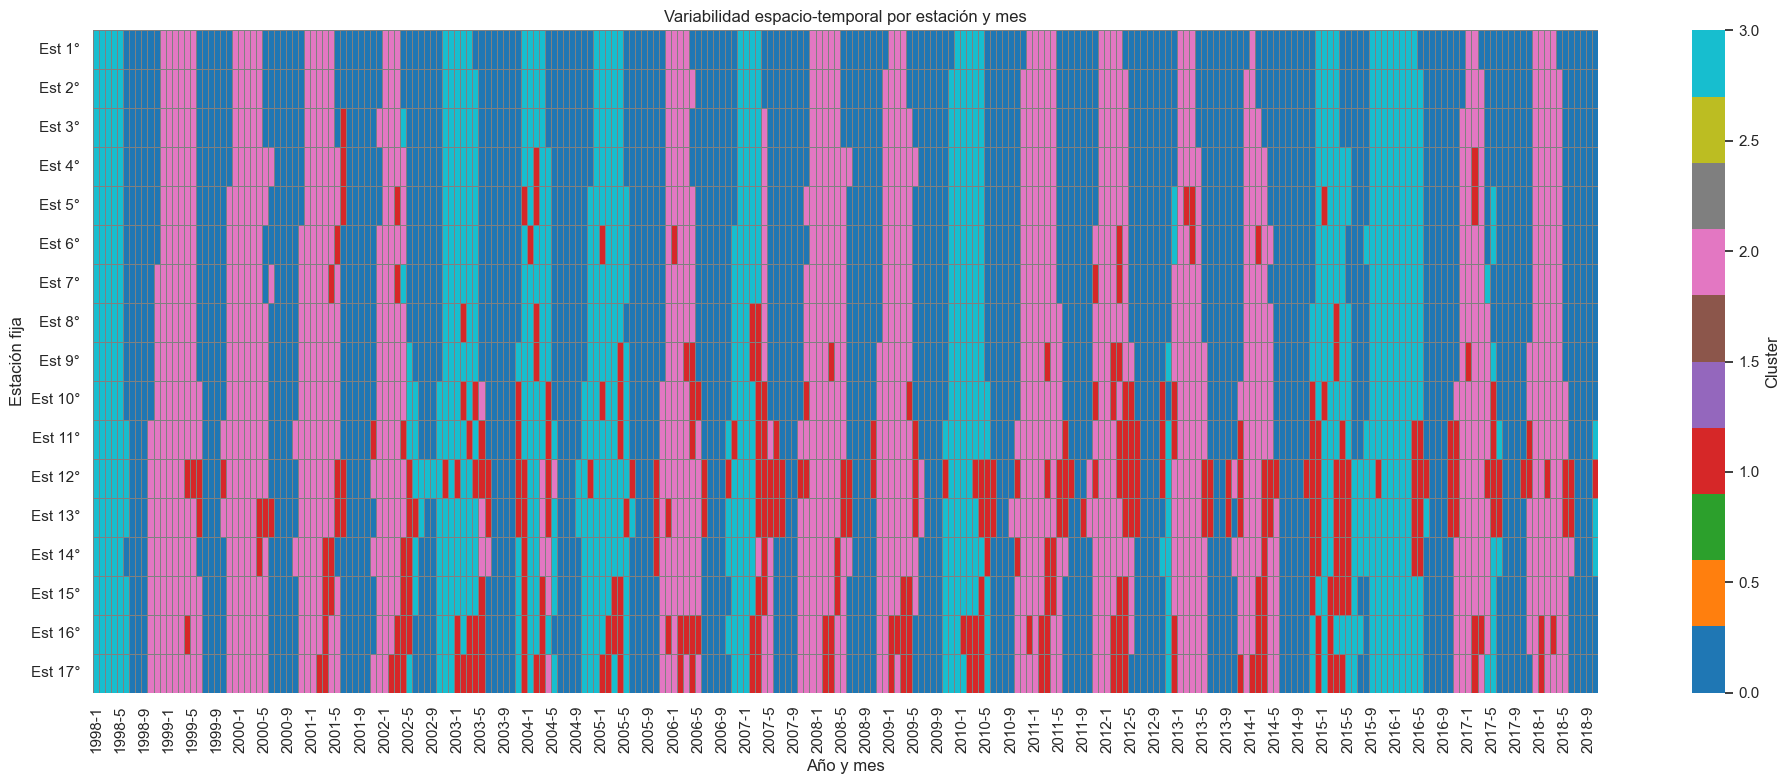

In [64]:
# Lista con el orden deseado
orden_estaciones = [f"Est {i}¬∞" for i in range(1, 18)]

# Reordenar el √≠ndice del heatmap
pivot_mensual = pivot_mensual.loc[orden_estaciones]
plt.figure(figsize=(20, 8))
sns.heatmap(pivot_mensual, cmap="tab10", linewidths=0.5, linecolor='gray', cbar_kws={"label": "Cluster"})
plt.title("Variabilidad espacio-temporal por estaci√≥n y mes")
plt.xlabel("A√±o y mes")
plt.ylabel("Estaci√≥n fija")
plt.tight_layout()
plt.show()

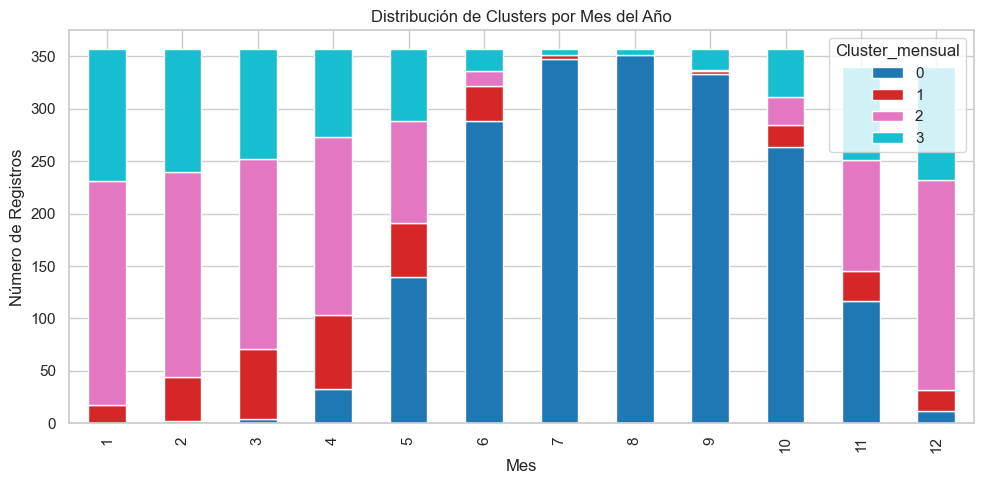

In [47]:
# Conteo de observaciones por mes y cluster
conteo_mes = agg_mensual.groupby(["MES_NUM", "Cluster_mensual"]).size().unstack(fill_value=0)

# Graficar
conteo_mes.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='tab10')
plt.title("Distribuci√≥n de Clusters por Mes del A√±o")
plt.xlabel("Mes")
plt.ylabel("N√∫mero de Registros")
plt.tight_layout()
plt.grid(True)
plt.show()


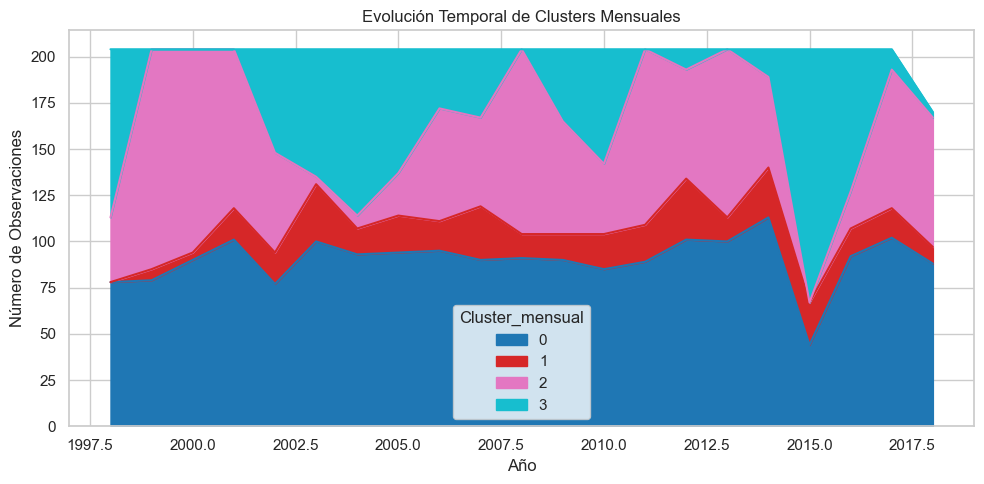

In [48]:
conteo_ano = agg_mensual.groupby(["A√ëO", "Cluster_mensual"]).size().unstack(fill_value=0)

conteo_ano.plot(kind='area', stacked=True, figsize=(10, 5), colormap='tab10')
plt.title("Evoluci√≥n Temporal de Clusters Mensuales")
plt.xlabel("A√±o")
plt.ylabel("N√∫mero de Observaciones")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# Ordenar para garantizar secuencia correcta
agg_mensual_sorted = agg_mensual.sort_values(["estacion", "A√ëO", "MES_NUM"])

# Detectar cambios de cluster de un mes al siguiente dentro del mismo a√±o
agg_mensual_sorted["Cambio"] = agg_mensual_sorted.groupby(["estacion", "A√ëO"])["Cluster_mensual"].diff().fillna(0).ne(0).astype(int)

# Contar cu√°ntos cambios por estaci√≥n y a√±o
cambios_mensuales = agg_mensual_sorted.groupby(["estacion", "A√ëO"])["Cambio"].sum().reset_index()

# Sumar cambios totales por estaci√≥n (entre todos los a√±os)
inestabilidad_mensual = cambios_mensuales.groupby("estacion")["Cambio"].sum().reset_index()
inestabilidad_mensual.columns = ["estacion", "cambios_mensuales_total"]

inestabilidad_mensual


estacion  cambios_mensuales_total
0   Est 10¬∞                       64
1   Est 11¬∞                       74
2   Est 12¬∞                       89
3   Est 13¬∞                       77
4   Est 14¬∞                       66
5   Est 15¬∞                       71
6   Est 16¬∞                       77
7   Est 17¬∞                       77
8    Est 1¬∞                       36
9    Est 2¬∞                       38
10   Est 3¬∞                       44
11   Est 4¬∞                       45
12   Est 5¬∞                       53
13   Est 6¬∞                       54
14   Est 7¬∞                       52
15   Est 8¬∞                       49
16   Est 9¬∞                       60

In [50]:
# Coordenadas por estaci√≥n
coords_mensual = agg_mensual.groupby("estacion")[["lat", "lon"]].first().reset_index()
mapa_mensual = pd.merge(inestabilidad_mensual, coords_mensual, on="estacion", how="left")

# Clasificaci√≥n de inestabilidad
def clasificar_mensual(n):
    if n >= 200:
        return 'Muy alta'
    elif n >= 120:
        return 'Media'
    else:
        return 'Baja'

mapa_mensual["nivel_inestabilidad"] = mapa_mensual["cambios_mensuales_total"].apply(clasificar_mensual)

# Colores por nivel
colores_mensual = {
    "Muy alta": "red",
    "Media": "orange",
    "Baja": "green"
}

# Crear mapa
m = folium.Map(location=[27.5, -111.5], zoom_start=6, tiles="CartoDB positron")

for _, row in mapa_mensual.iterrows():
    color = colores_mensual[row["nivel_inestabilidad"]]
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=5 + row["cambios_mensuales_total"] * 0.05,
        popup=(f"{row['estacion']}<br>Cambios mensuales: {row['cambios_mensuales_total']}<br>Nivel: {row['nivel_inestabilidad']}"),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8
    ).add_to(m)

m


In [51]:
# Crear columna con cluster del siguiente mes
agg_mensual_sorted["Cluster_siguiente"] = agg_mensual_sorted.groupby(["estacion", "A√ëO"])["Cluster_mensual"].shift(-1)

# Eliminar donde no hay siguiente mes
transiciones_mensuales = agg_mensual_sorted.dropna(subset=["Cluster_siguiente"])
transiciones_mensuales["Cluster_mensual"] = transiciones_mensuales["Cluster_mensual"].astype(int)
transiciones_mensuales["Cluster_siguiente"] = transiciones_mensuales["Cluster_siguiente"].astype(int)

# Crear matriz
matriz_trans_mensual = pd.crosstab(
    transiciones_mensuales["Cluster_mensual"],
    transiciones_mensuales["Cluster_siguiente"],
    rownames=["Cluster_actual"],
    colnames=["Cluster_siguiente"]
)

# Normalizar por fila
matriz_trans_mensual_norm = matriz_trans_mensual.div(matriz_trans_mensual.sum(axis=1), axis=0).round(2)

matriz_trans_mensual

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\3620869868.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11372\3620869868.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster_siguiente     0    1    2    3
Cluster_actual                        
0                  1533   43  176  115
1                    58  134   85   58
2                   182   97  714   12
3                   119   65   16  486